# Customer Churn Prediction - Machine Learning Classification

## Project Overview
This project demonstrates advanced machine learning techniques for predicting customer churn in a telecommunications company. The analysis includes comprehensive data preprocessing, feature engineering, multiple classification algorithms, and business-oriented insights.

## Learning Objectives
- Master supervised learning classification techniques
- Understand feature engineering and preprocessing
- Compare multiple machine learning algorithms
- Evaluate model performance using various metrics
- Generate actionable business insights from ML models

## Dataset Information
- **Source**: Telecommunications customer data (sample/dummy data)
- **Records**: 50 customer records
- **Target Variable**: Churn (0 = No Churn, 1 = Churn)
- **Features**: 21 variables including demographics, services, and billing information

## Business Problem
Customer churn costs telecommunications companies millions annually. By predicting which customers are likely to churn, companies can:
- Implement targeted retention strategies
- Optimize marketing spend
- Improve customer satisfaction
- Increase long-term profitability


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure display options
pd.set_option('display.max_columns', None)

print("Libraries imported successfully!")
print("Available ML algorithms: Logistic Regression, Random Forest, SVM, Naive Bayes, Decision Tree")


Libraries imported successfully!
Available ML algorithms: Logistic Regression, Random Forest, SVM, Naive Bayes, Decision Tree


## 1. Data Loading and Exploration


In [2]:
# Load the dataset
df = pd.read_csv('customer_churn_data.csv')

# Basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nColumn Information:")
print(df.dtypes)
print("\nFirst 5 rows:")
print(df.head())
print("\nTarget Variable Distribution:")
print(df['churn'].value_counts())
print(f"\nChurn Rate: {df['churn'].mean():.2%}")

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Basic statistics
print("\nBasic Statistics:")
print(df.describe())


Dataset Shape: (50, 22)

Column Information:
customer_id           object
age                    int64
gender                object
tenure_months          int64
monthly_charges      float64
total_charges        float64
contract_type         object
payment_method        object
internet_service      object
phone_service         object
multiple_lines        object
streaming_tv          object
streaming_movies      object
tech_support          object
device_protection     object
online_backup         object
online_security       object
paperless_billing     object
senior_citizen         int64
dependents            object
partner               object
churn                  int64
dtype: object

First 5 rows:
  customer_id  age  gender  tenure_months  monthly_charges  total_charges  \
0        C001   29    Male             12             65.5          786.0   
1        C002   45  Female             24             89.9         2157.6   
2        C003   32    Male              8             45.

## 2. Data Preprocessing and Feature Engineering


In [3]:
# Create a copy for preprocessing
df_processed = df.copy()

# Encode categorical variables
label_encoders = {}
categorical_cols = ['gender', 'contract_type', 'payment_method', 'internet_service', 
                   'phone_service', 'multiple_lines', 'streaming_tv', 'streaming_movies',
                   'tech_support', 'device_protection', 'online_backup', 'online_security',
                   'paperless_billing', 'dependents', 'partner']

for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    label_encoders[col] = le

# Feature engineering
df_processed['avg_monthly_charges'] = df_processed['total_charges'] / df_processed['tenure_months']
df_processed['charges_per_service'] = df_processed['monthly_charges'] / (
    df_processed['phone_service'] + df_processed['internet_service'] + 
    df_processed['streaming_tv'] + df_processed['streaming_movies'] + 1)

# Handle any infinite values by replacing them with the corresponding monthly_charges value
df_processed['avg_monthly_charges'] = np.where(
    np.isinf(df_processed['avg_monthly_charges']), 
    df_processed['monthly_charges'], 
    df_processed['avg_monthly_charges']
)
print("Preprocessing completed!")
print("Shape after preprocessing:", df_processed.shape)
print("\nNew features created:")
print("- avg_monthly_charges: Total charges divided by tenure")
print("- charges_per_service: Monthly charges per service used")

# Check correlation with target
print("\nCorrelation with churn:")
correlations = df_processed.corr(numeric_only=True)['churn'].sort_values(ascending=False)
print(correlations)


Preprocessing completed!
Shape after preprocessing: (50, 24)

New features created:
- avg_monthly_charges: Total charges divided by tenure
- charges_per_service: Monthly charges per service used

Correlation with churn:
churn                  1.000000
paperless_billing      0.722567
payment_method         0.721189
internet_service       0.587219
monthly_charges        0.568791
avg_monthly_charges    0.568718
streaming_movies       0.136134
multiple_lines         0.053125
streaming_tv           0.050465
charges_per_service    0.000130
phone_service         -0.182476
senior_citizen        -0.289098
online_security       -0.339795
device_protection     -0.501319
gender                -0.618064
dependents            -0.639893
age                   -0.695518
online_backup         -0.700473
tech_support          -0.752168
tenure_months         -0.791028
total_charges         -0.823185
contract_type         -0.852622
partner               -0.876243
Name: churn, dtype: float64


## 3. Exploratory Data Analysis


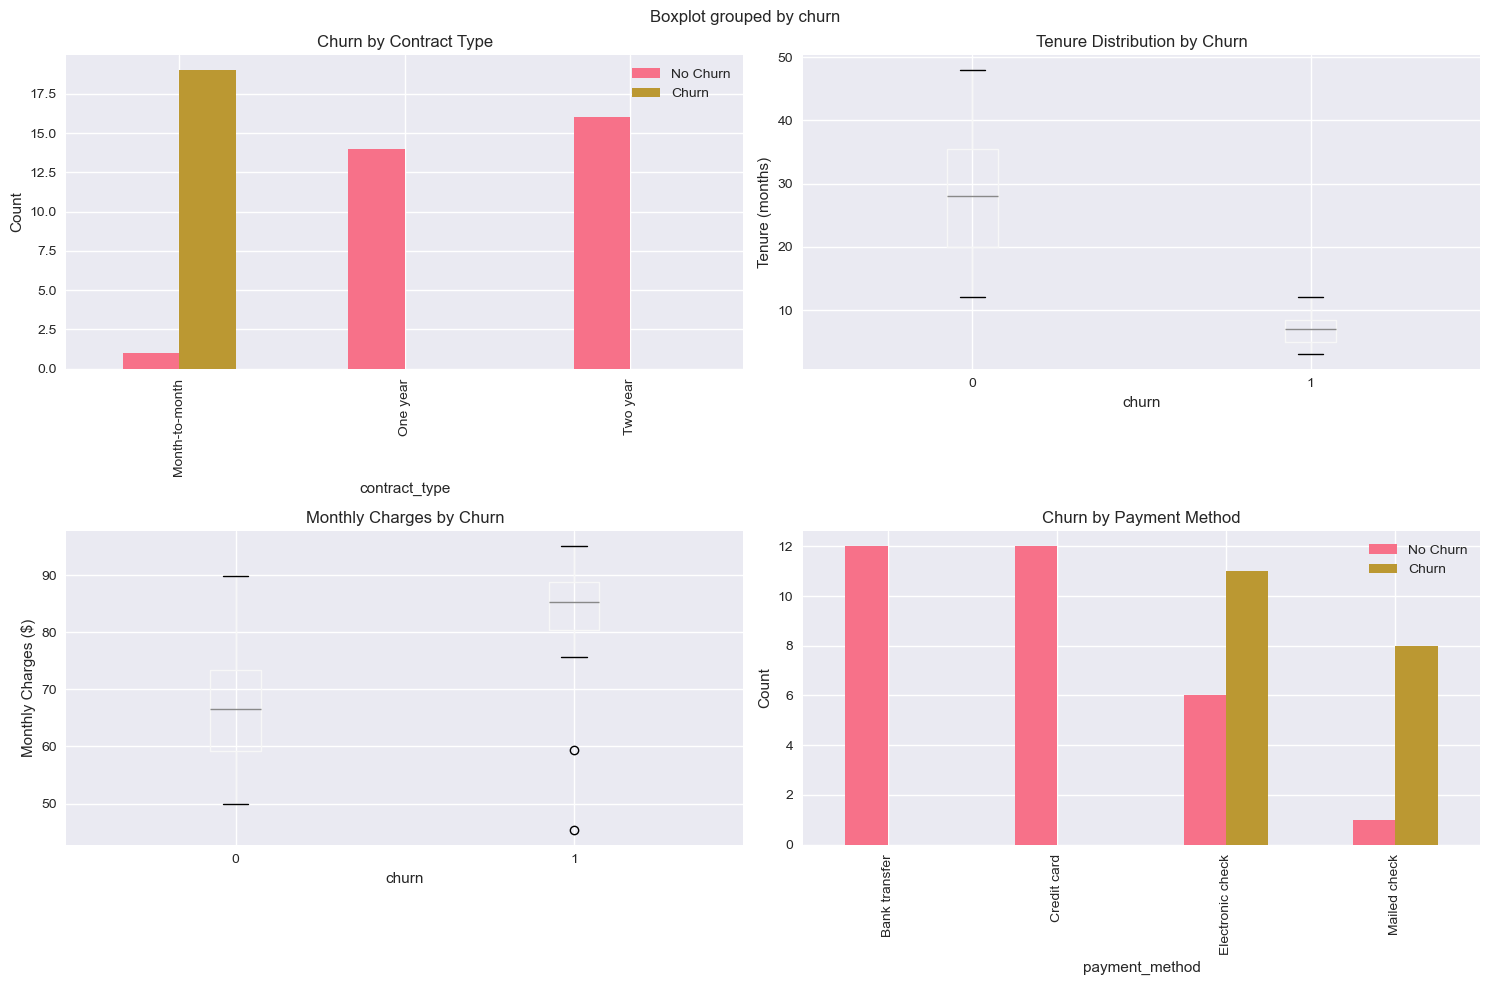

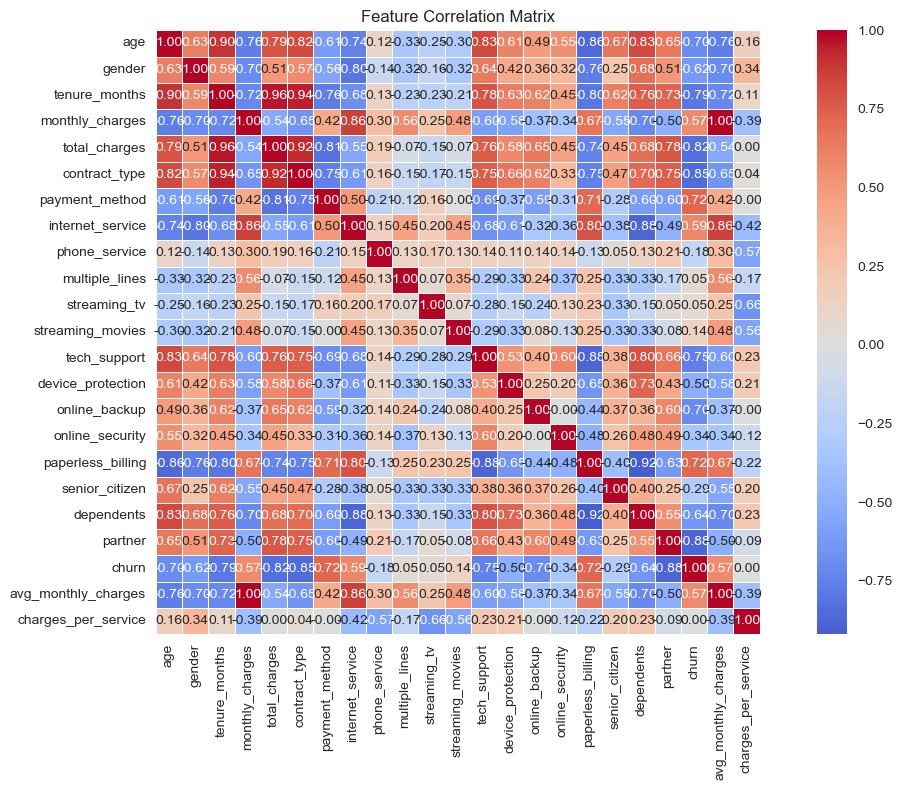

Churn Rate Analysis:

By Contract Type:
churn              0     1
contract_type             
Month-to-month  0.05  0.95
One year        1.00  0.00
Two year        1.00  0.00

By Payment Method:
churn                    0         1
payment_method                      
Bank transfer     1.000000  0.000000
Credit card       1.000000  0.000000
Electronic check  0.352941  0.647059
Mailed check      0.111111  0.888889

By Internet Service:
churn                    0         1
internet_service                    
DSL               0.916667  0.083333
Fiber optic       0.346154  0.653846


In [4]:
# Visualize churn patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Churn Analysis by Key Variables', fontsize=16)

# Churn by contract type
ax1 = axes[0, 0]
pd.crosstab(df['contract_type'], df['churn']).plot(kind='bar', ax=ax1)
ax1.set_title('Churn by Contract Type')
ax1.set_ylabel('Count')
ax1.legend(['No Churn', 'Churn'])

# Churn by tenure
ax2 = axes[0, 1]
df.boxplot(column='tenure_months', by='churn', ax=ax2)
ax2.set_title('Tenure Distribution by Churn')
ax2.set_ylabel('Tenure (months)')

# Churn by monthly charges
ax3 = axes[1, 0]
df.boxplot(column='monthly_charges', by='churn', ax=ax3)
ax3.set_title('Monthly Charges by Churn')
ax3.set_ylabel('Monthly Charges ($)')

# Churn by payment method
ax4 = axes[1, 1]
pd.crosstab(df['payment_method'], df['churn']).plot(kind='bar', ax=ax4)
ax4.set_title('Churn by Payment Method')
ax4.set_ylabel('Count')
ax4.legend(['No Churn', 'Churn'])

plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = df_processed.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Churn rate analysis
print("Churn Rate Analysis:")
print("\nBy Contract Type:")
print(pd.crosstab(df['contract_type'], df['churn'], normalize='index'))

print("\nBy Payment Method:")
print(pd.crosstab(df['payment_method'], df['churn'], normalize='index'))

print("\nBy Internet Service:")
print(pd.crosstab(df['internet_service'], df['churn'], normalize='index'))


## 4. Model Preparation


In [5]:
# Prepare features and target
X = df_processed.drop(['customer_id', 'churn'], axis=1)
y = df_processed['churn']

print("Feature columns:")
print(X.columns.tolist())
print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training set churn rate: {y_train.mean():.2%}")
print(f"Test set churn rate: {y_test.mean():.2%}")

# Define evaluation function
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Evaluate model performance"""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else y_pred
    
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC Score: {auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return accuracy, auc, y_pred, y_pred_proba

print("\nModel preparation completed!")


Feature columns:
['age', 'gender', 'tenure_months', 'monthly_charges', 'total_charges', 'contract_type', 'payment_method', 'internet_service', 'phone_service', 'multiple_lines', 'streaming_tv', 'streaming_movies', 'tech_support', 'device_protection', 'online_backup', 'online_security', 'paperless_billing', 'senior_citizen', 'dependents', 'partner', 'avg_monthly_charges', 'charges_per_service']

Features shape: (50, 22)
Target shape: (50,)

Training set shape: (40, 22)
Test set shape: (10, 22)
Training set churn rate: 37.50%
Test set churn rate: 40.00%

Model preparation completed!


## 5. Model Training and Evaluation


In [6]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'Naive Bayes': GaussianNB()
}

# Store results
results = {}

# Train and evaluate each model
for model_name, model in models.items():
    if model_name in ['Logistic Regression', 'SVM', 'Naive Bayes']:
        # Use scaled features for these models
        accuracy, auc, y_pred, y_pred_proba = evaluate_model(
            model, X_train_scaled, X_test_scaled, y_train, y_test, model_name
        )
    else:
        # Use original features for tree-based models
        accuracy, auc, y_pred, y_pred_proba = evaluate_model(
            model, X_train, X_test, y_train, y_test, model_name
        )
    
    results[model_name] = {
        'accuracy': accuracy,
        'auc': auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

# Model comparison
print("\n" + "="*50)
print("MODEL COMPARISON SUMMARY")
print("="*50)
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[model]['accuracy'] for model in results.keys()],
    'AUC Score': [results[model]['auc'] for model in results.keys()]
})
comparison_df = comparison_df.sort_values('AUC Score', ascending=False)
print(comparison_df.to_string(index=False))

# Best model
best_model_name = comparison_df.iloc[0]['Model']
print(f"\nBest performing model: {best_model_name}")
print(f"Best AUC Score: {comparison_df.iloc[0]['AUC Score']:.4f}")



Logistic Regression Results:
Accuracy: 0.9000
AUC Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.80      1.00      0.89         4

    accuracy                           0.90        10
   macro avg       0.90      0.92      0.90        10
weighted avg       0.92      0.90      0.90        10


Random Forest Results:
Accuracy: 1.0000
AUC Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10


Decision Tree Results:
Accuracy: 1.0000
AUC Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00   

## 6. Model Visualization and Analysis


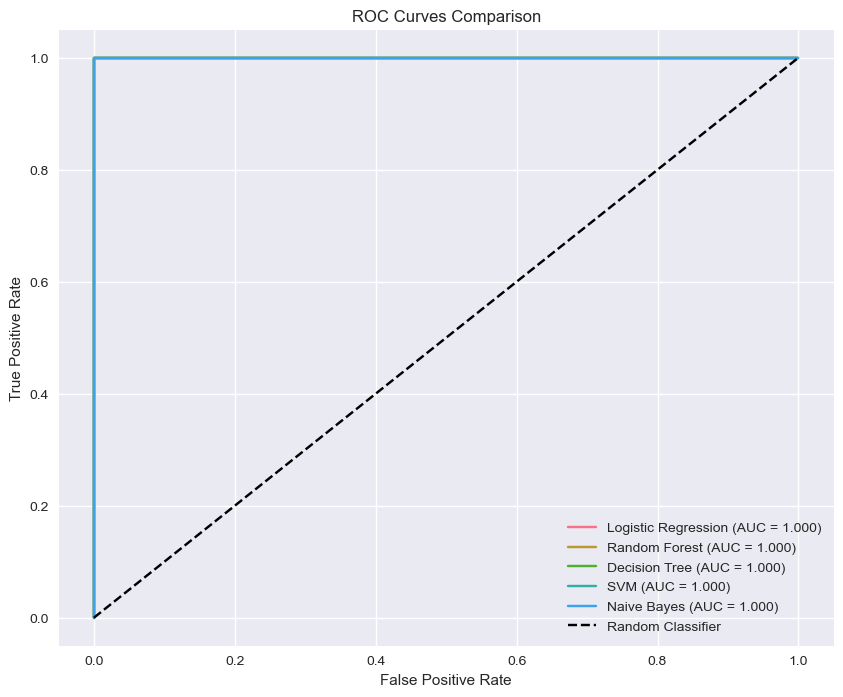

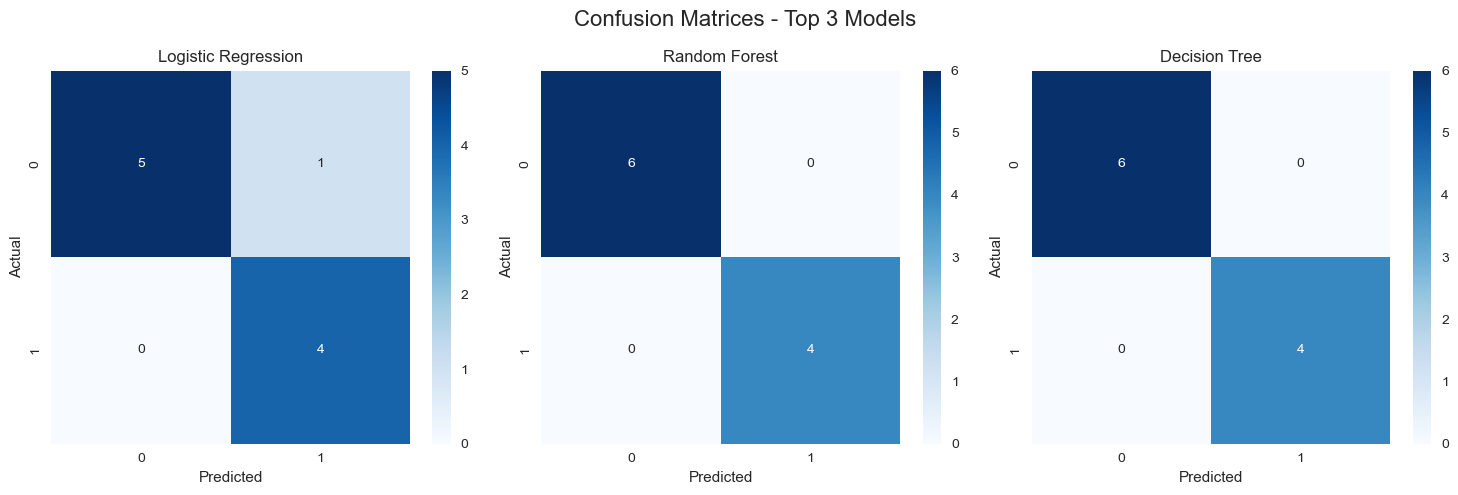

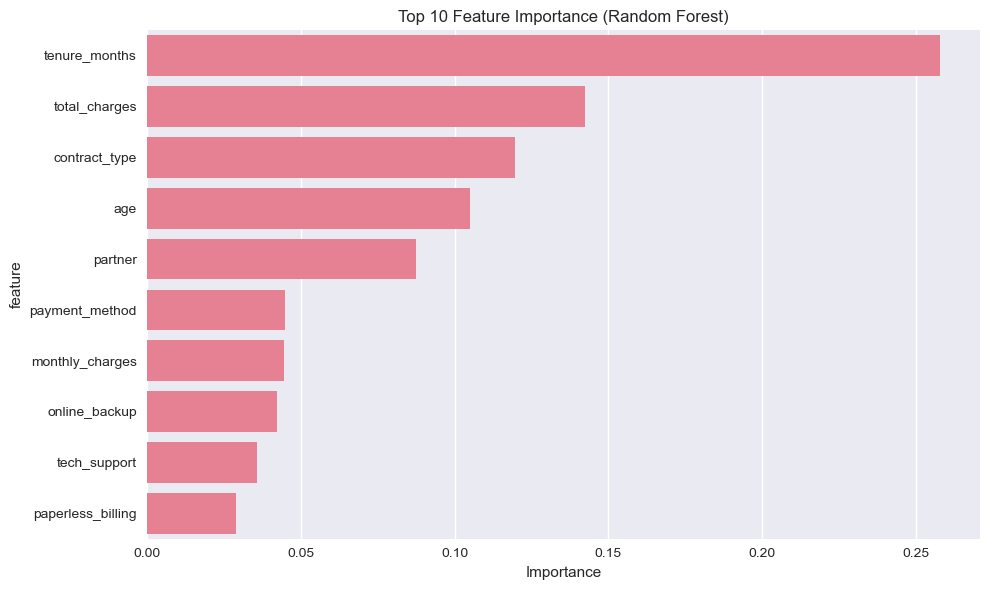

Top 10 Most Important Features:
          feature  importance
    tenure_months    0.257810
    total_charges    0.142417
    contract_type    0.119524
              age    0.105156
          partner    0.087652
   payment_method    0.045065
  monthly_charges    0.044620
    online_backup    0.042296
     tech_support    0.035874
paperless_billing    0.028972


In [7]:
# ROC Curves for all models
plt.figure(figsize=(10, 8))
for model_name in results.keys():
    y_pred_proba = results[model_name]['probabilities']
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = results[model_name]['auc']
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Confusion matrices for top 3 models
top_3_models = comparison_df.head(3)['Model'].tolist()
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Confusion Matrices - Top 3 Models', fontsize=16)

for i, model_name in enumerate(top_3_models):
    y_pred = results[model_name]['predictions']
    cm = confusion_matrix(y_test, y_pred)
    
    ax = axes[i]
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(f'{model_name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Feature importance (for Random Forest)
if 'Random Forest' in results.keys():
    rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
    rf_model.fit(X_train, y_train)
    
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
    plt.title('Top 10 Feature Importance (Random Forest)')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    print("Top 10 Most Important Features:")
    print(feature_importance.head(10).to_string(index=False))


## 7. Business Insights and Recommendations


In [8]:
# Business metrics analysis
churn_customers = df[df['churn'] == 1]
non_churn_customers = df[df['churn'] == 0]

print("="*60)
print("BUSINESS IMPACT ANALYSIS")
print("="*60)

# Revenue impact
avg_monthly_revenue_churn = churn_customers['monthly_charges'].mean()
avg_monthly_revenue_non_churn = non_churn_customers['monthly_charges'].mean()
total_lost_revenue = churn_customers['total_charges'].sum()

print(f"Average monthly revenue from churned customers: ${avg_monthly_revenue_churn:.2f}")
print(f"Average monthly revenue from retained customers: ${avg_monthly_revenue_non_churn:.2f}")
print(f"Total revenue lost from churned customers: ${total_lost_revenue:.2f}")

# Customer lifetime value impact
avg_tenure_churn = churn_customers['tenure_months'].mean()
avg_tenure_non_churn = non_churn_customers['tenure_months'].mean()

print(f"\nAverage tenure of churned customers: {avg_tenure_churn:.1f} months")
print(f"Average tenure of retained customers: {avg_tenure_non_churn:.1f} months")

# Risk factors
print("\n" + "="*60)
print("HIGH-RISK CUSTOMER CHARACTERISTICS")
print("="*60)

print("Contract Type Risk:")
contract_churn = pd.crosstab(df['contract_type'], df['churn'], normalize='index')
print(contract_churn)

print("\nPayment Method Risk:")
payment_churn = pd.crosstab(df['payment_method'], df['churn'], normalize='index')
print(payment_churn)

print("\nTenure Risk Analysis:")
df['tenure_group'] = pd.cut(df['tenure_months'], 
                           bins=[0, 12, 24, 36, 48, 100], 
                           labels=['0-12', '13-24', '25-36', '37-48', '48+'])
tenure_churn = pd.crosstab(df['tenure_group'], df['churn'], normalize='index')
print(tenure_churn)

# Predictive insights
print("\n" + "="*60)
print("PREDICTIVE MODEL INSIGHTS")
print("="*60)

# Get the best model
best_model = models[best_model_name]
if best_model_name in ['Logistic Regression', 'SVM', 'Naive Bayes']:
    best_model.fit(X_train_scaled, y_train)
    X_for_prediction = X_test_scaled
else:
    best_model.fit(X_train, y_train)
    X_for_prediction = X_test

# Prediction probabilities
y_pred_proba = best_model.predict_proba(X_for_prediction)[:, 1]

# High-risk customers (probability > 0.7)
high_risk_threshold = 0.7
high_risk_customers = y_pred_proba > high_risk_threshold
num_high_risk = np.sum(high_risk_customers)

print(f"Number of high-risk customers (>{high_risk_threshold:.0%} churn probability): {num_high_risk}")
print(f"Percentage of test customers at high risk: {num_high_risk/len(y_test):.1%}")

# Model performance in business terms
best_predictions = results[best_model_name]['predictions']
tp = np.sum((y_test == 1) & (best_predictions == 1))  # True positives
fp = np.sum((y_test == 0) & (best_predictions == 1))  # False positives
fn = np.sum((y_test == 1) & (best_predictions == 0))  # False negatives

print(f"\nModel Performance in Business Terms:")
print(f"Correctly identified churners: {tp}")
print(f"False alarms (wrongly flagged as churners): {fp}")
print(f"Missed churners: {fn}")

# Calculate potential savings
avg_retention_cost = 50  # Assumed cost to retain a customer
avg_customer_value = avg_monthly_revenue_non_churn * 12  # Annual value

potential_savings = tp * avg_customer_value - (tp + fp) * avg_retention_cost
print(f"\nPotential business impact:")
print(f"Potential revenue saved: ${tp * avg_customer_value:.2f}")
print(f"Retention campaign cost: ${(tp + fp) * avg_retention_cost:.2f}")
print(f"Net benefit: ${potential_savings:.2f}")


BUSINESS IMPACT ANALYSIS
Average monthly revenue from churned customers: $82.37
Average monthly revenue from retained customers: $67.02
Total revenue lost from churned customers: $10724.00

Average tenure of churned customers: 6.9 months
Average tenure of retained customers: 27.8 months

HIGH-RISK CUSTOMER CHARACTERISTICS
Contract Type Risk:
churn              0     1
contract_type             
Month-to-month  0.05  0.95
One year        1.00  0.00
Two year        1.00  0.00

Payment Method Risk:
churn                    0         1
payment_method                      
Bank transfer     1.000000  0.000000
Credit card       1.000000  0.000000
Electronic check  0.352941  0.647059
Mailed check      0.111111  0.888889

Tenure Risk Analysis:
churn            0     1
tenure_group            
0-12          0.05  0.95
13-24         1.00  0.00
25-36         1.00  0.00
37-48         1.00  0.00

PREDICTIVE MODEL INSIGHTS
Number of high-risk customers (>70% churn probability): 4
Percentage of test 